# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #2

In [16]:
import sys
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from pylab import cm
from scipy.optimize import minimize

(13, 1024)


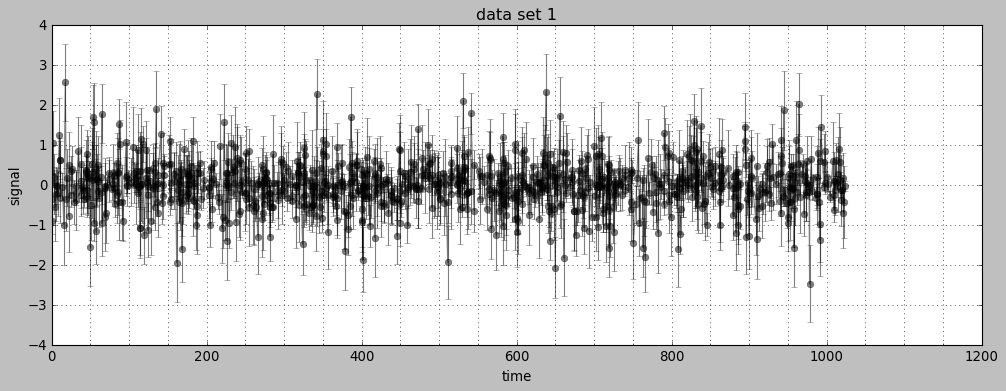

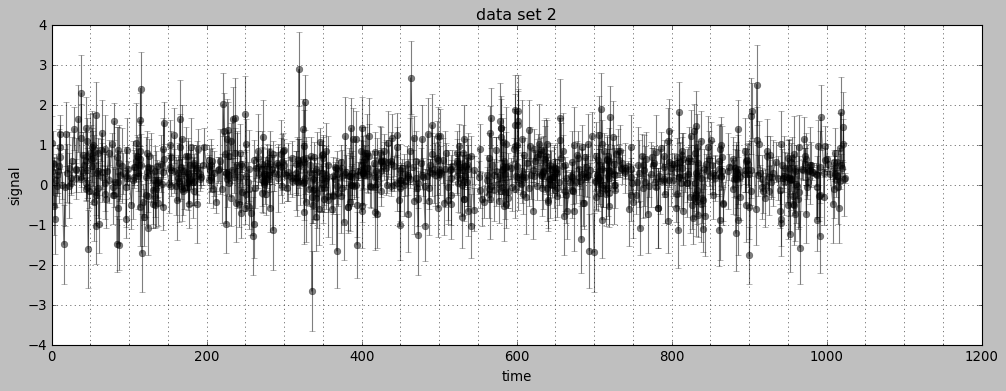

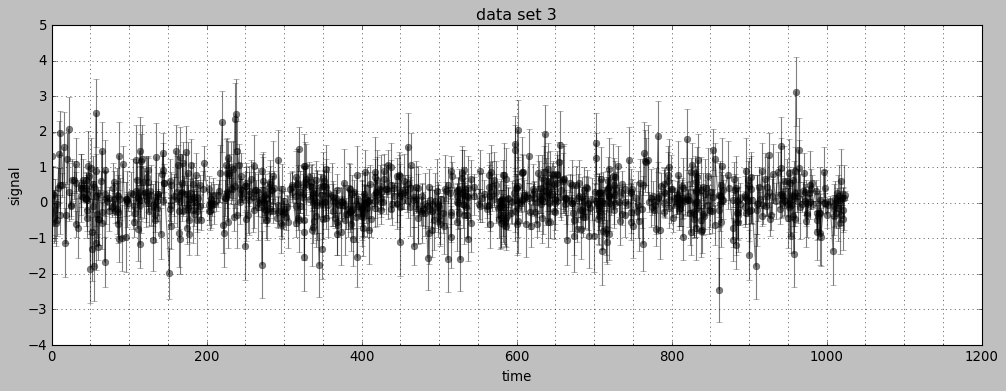

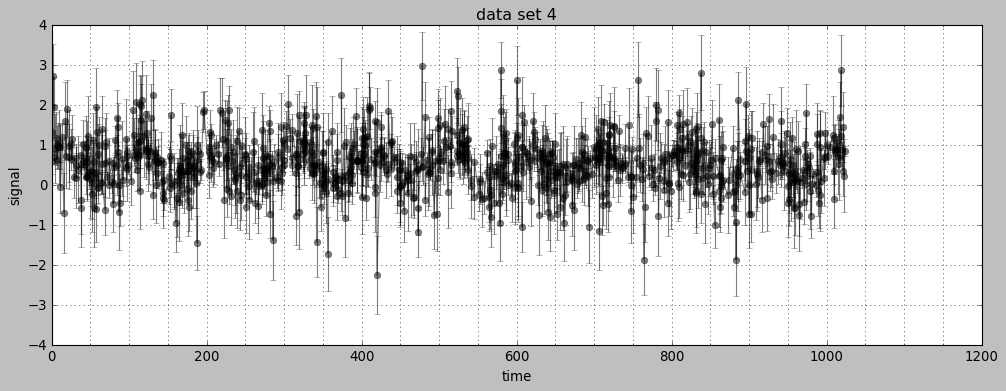

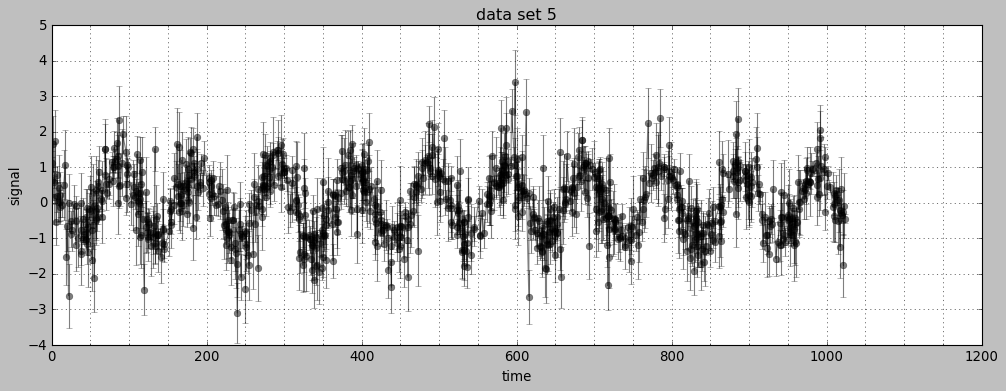

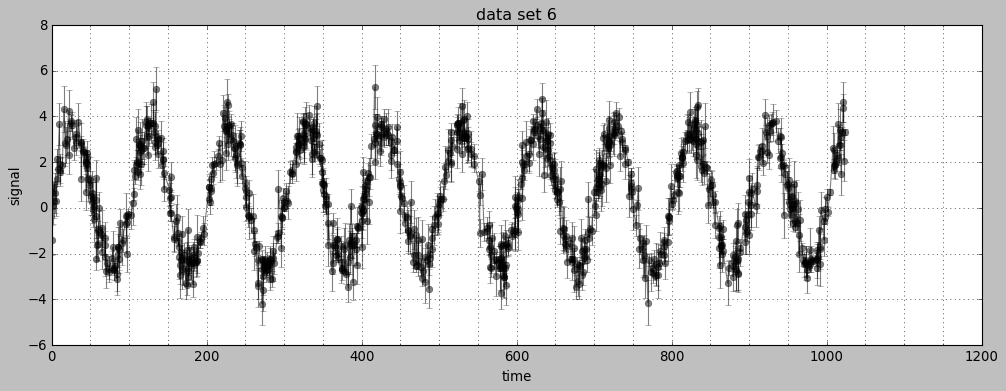

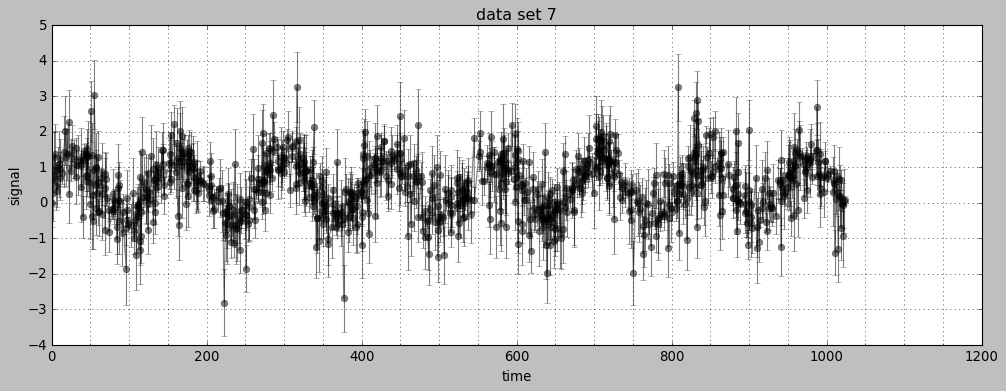

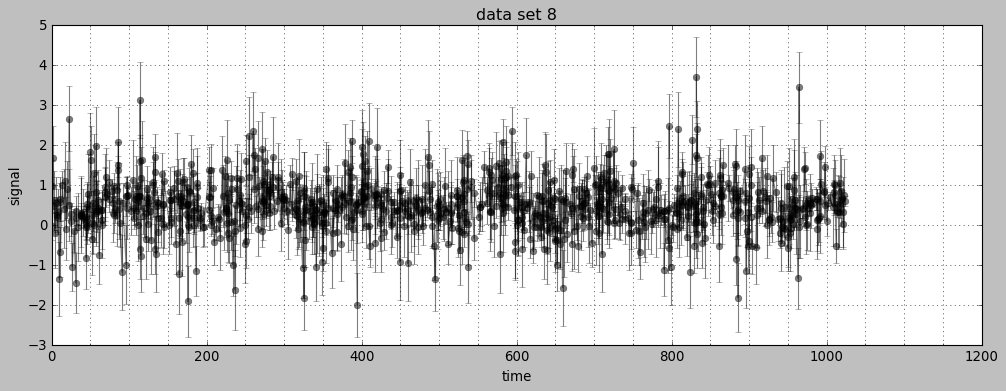

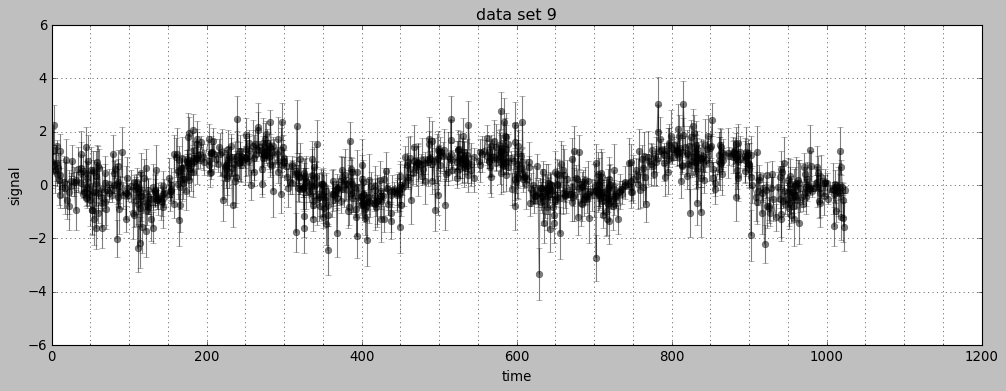

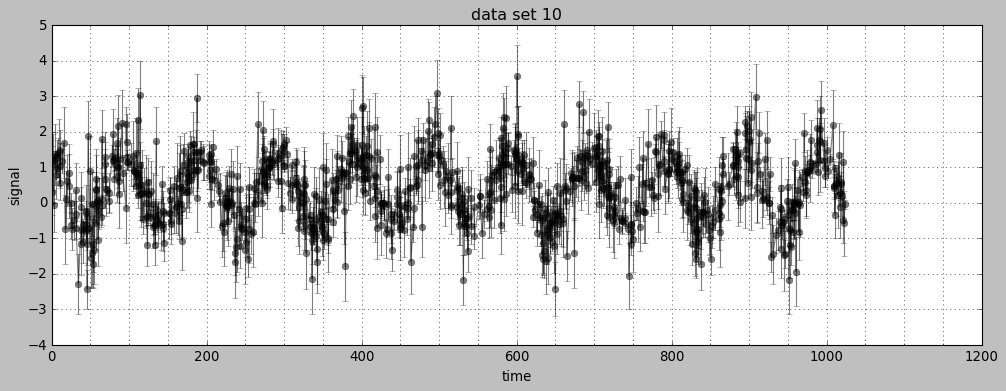

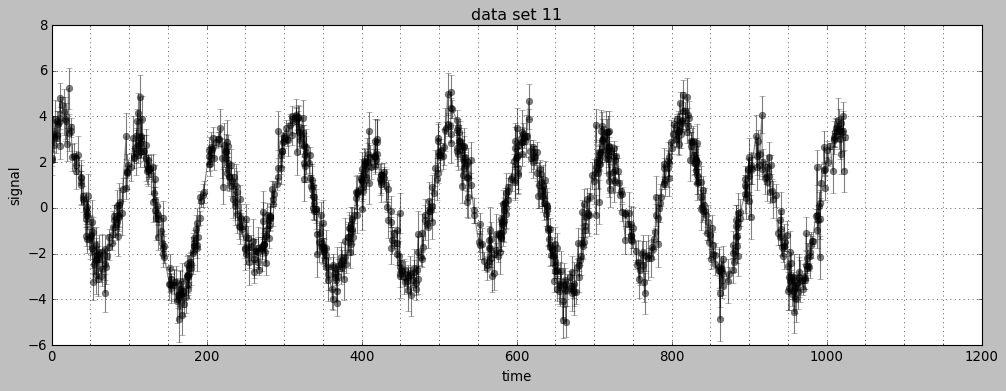

In [17]:
#with open('data.pkl', 'rb') as f:
#    data = pickle.load(f)
#print(data)

with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.
for i in range(2, 13):
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", marker="o", alpha=0.5)
    pyplt.xlabel("time")
    pyplt.ylabel("signal")
    pyplt.title("data set {}".format(i-1))

## Exercise 1 

For each dataset above, detect and characterize a sinusoidal signal with a 100day period. 

## Exercise 2
For each dataset above, is there another sinusoidal signal with a 100day period other than one in exercise 1?

## Exercise 3
For each dataset above, treat the signal found in excercise 2 as nuisance parameters and repeat exercise 1.
Are there any changes? 

## Background for my solutions

By assuming that each dataset can be generated by a probablistic model of zero/one/two sinosoidal signals, we can build a set of models $M_0, M_1, M_2$.

### $M_0$
For the probabilistic model $M_0$, assuming the data contains no sinusoidal signals (aka the null hypothesis):   
$$
\begin{align}
\mu_i =  \epsilon_i + B
\end{align}
$$
where,
- $\{(t_i,y_i)\}$ is the given data set, generated by a process with only noise $\epsilon_i$ and a DC shift $B$.
- $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$ is the Gaussian noise for each data point with a mean of 0 and given variance $\sigma_i^2$.

### $M_1$
For the probabilistic generative model $M_1$, assuming the data contains one sinosoidal signal:

$$ 
\begin{align}
\mu_i &= A \cos(\frac{2\pi}{T } t +\phi) + \epsilon_i + B \\
\end{align}
$$

To account for the phase, we decompose the signal into sin and cos

$$
\begin{align}
\mu_i &= A_1 \cos(\frac{2\pi}{T } t) + A_2 \sin(\frac{2\pi}{T } t) + \epsilon_i + B \\
\end{align}
$$

where,
- The signal has given period $T=100days$, amplitudes $A_1$ and $A_2$ and DC shift $B$. 
- $\{(t_i,y_i)\}$ is the given data set, and $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$ is the Gaussian noise for each data point with a mean of 0 and given variance $\sigma_i^2$.

### $M_2$
For the probabilistic model $M_2$, assuming the data contains two sinosoidal signal:

$$ 
\begin{align}
\mu_i &= A' \cos(\frac{2\pi}{T'} t +\phi') + A \cos(\frac{2\pi}{T} t +\phi) + \epsilon_i + B \\
\end{align}
$$

To account for the phases, we decompose the signals into sin and cos

$$ 
\begin{align}
\mu_i &= A_3 \cos(\frac{2\pi}{T'} t) + A_4 \sin(\frac{2\pi}{T'} t) + A_1 \cos(\frac{2\pi}{T} t) + A_2 \sin(\frac{2\pi}{T} t) + \epsilon_i + B \\
\end{align}
$$

where, 
- One signal has given period $T=100days$ and amplitudes $A_1$ and $A_2$ 
- A second signal has unknown period $T'$ and amplitudes $A_3$ and $A_4$
- A total DC shift $B$. 
- $\{(t_i,y_i)\}$ is the given data set, and $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$ is the Gaussian noise for each data point with a mean of 0 and given variance $\sigma_i^2$.

## Solution - Exercise 1 
#### Task: For each dataset above, detect and characterize a sinusoidal signal with a 100day period.

Using model $M_1$, the likelihood function ${\mathcal {L}_1}$ is:
$$ {\mathcal {L}_1} = -\frac{1}{2} \sum \limits _{i} ^{N} \frac{ [y_i - \mu_i]^2}{\sigma_i^2} $$

We can use the log-likelihood function to derive the maximum likelihood estimation of the parameters $ \theta = A_1, A_2, B$ given the data $X$
$${\displaystyle {\hat {\theta }}=\operatorname {argmax} _{A_1, A_2, B \in \theta}{\mathcal {L}_1}(\theta \mid X)} $$

We can define the log-likelihood function by,
$$ loglike(pars, data, info) = \log\left[P(data|pars)\right] = \displaystyle {\hat \theta } $$
where,
- pars: model parameters $(A_1, A_2, B)$
- data: data points ($t_i, y_i)$, $1xN$ arrays $( [t_1, ... ,t_N],[y_1, ..., y_N] )$
- info: $y_i$ uncertainties $(\sigma_i)$, a $1xN$ array $[\sigma_1,...,\sigma_N]$

In [18]:
# Create the definition for our log-likelihood function and what it returns
def loglike_M1(pars, data, info):
    A1,A2,B = pars
    t, y = data
    sig = info

    # Create function for mu, using one signal with period of T = 100days    
    mu = A1 * np.cos(2* np.pi/100 * t) + A2 * np.sin(2* np.pi/100 * t) + B 

    return -0.5 * np.sum( ((y - mu)/sig )**2 )


## Test M1 log-likelihood function for aimple case if A1=1, A2=1, B=0
theta = (1,1,0)
loglike_M1(theta, (data[0],data[2]), data[1])

-5496.669193293843

Model 1 : dataset 1 --> A1 = 0.00895933444167208,  A2 = -0.0009323568732674155, B = 0.00508153535356215 
Model 1 : dataset 2 --> A1 = 0.02680687318461483,  A2 = 0.042534610570194475, B = 0.28640313229486936 
Model 1 : dataset 3 --> A1 = -0.08662208357869011,  A2 = 0.08813394238719202, B = 0.09560586942592174 
Model 1 : dataset 4 --> A1 = 0.18853248904018258,  A2 = 0.2498325780662389, B = 0.5235855208068473 
Model 1 : dataset 5 --> A1 = 0.7622605995327504,  A2 = -0.6185043722787834, B = 0.007465130494183696 
Model 1 : dataset 6 --> A1 = -0.4600899772492399,  A2 = 2.9716239888285396, B = 0.4600945202243455 
Model 1 : dataset 7 --> A1 = -0.03818781397412207,  A2 = -0.03799635965164621, B = 0.4927122420150479 
Model 1 : dataset 8 --> A1 = 0.07607086821357552,  A2 = -0.08244428710825237, B = 0.4908278764139188 
Model 1 : dataset 9 --> A1 = 0.24901590489831715,  A2 = -0.24356206745562897, B = 0.27217890850009063 
Model 1 : dataset 10 --> A1 = 0.864656731271497,  A2 = -0.45727323662040703, B 

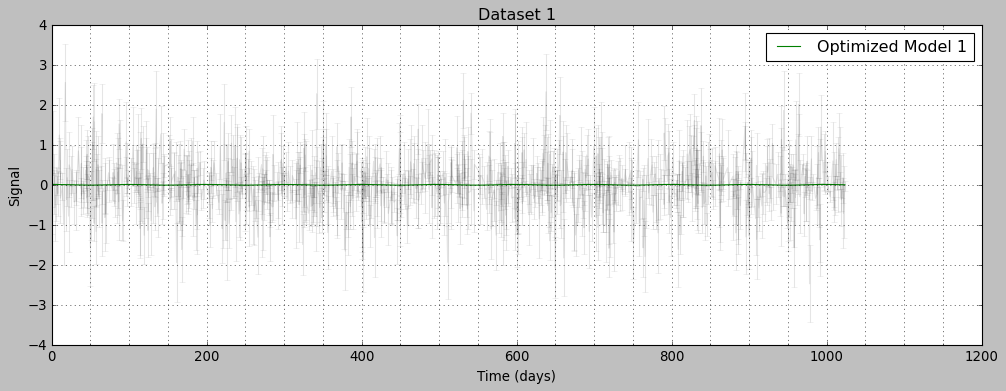

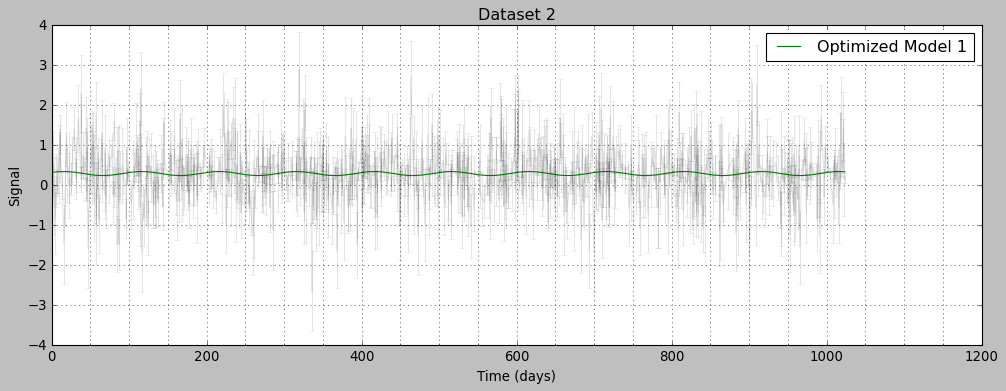

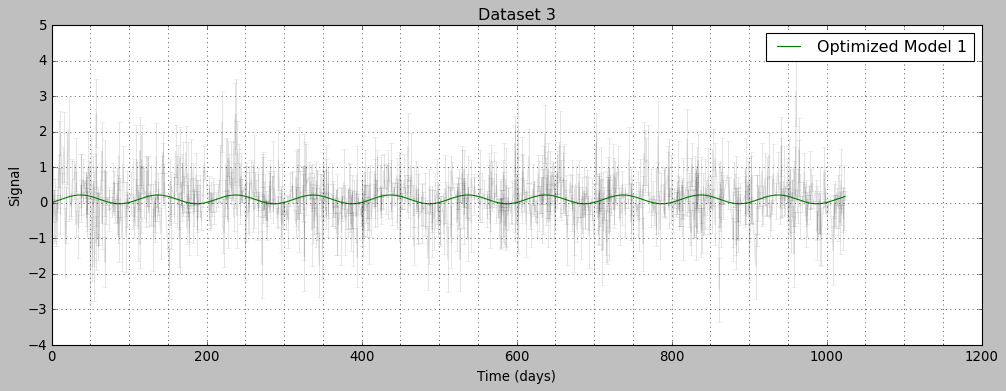

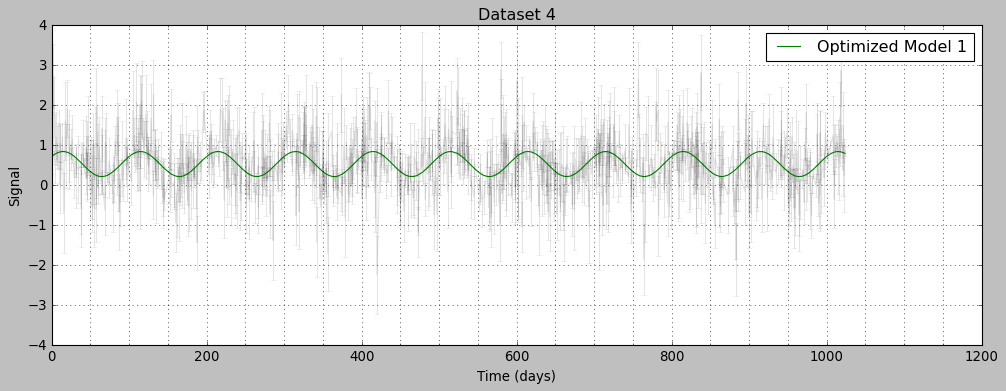

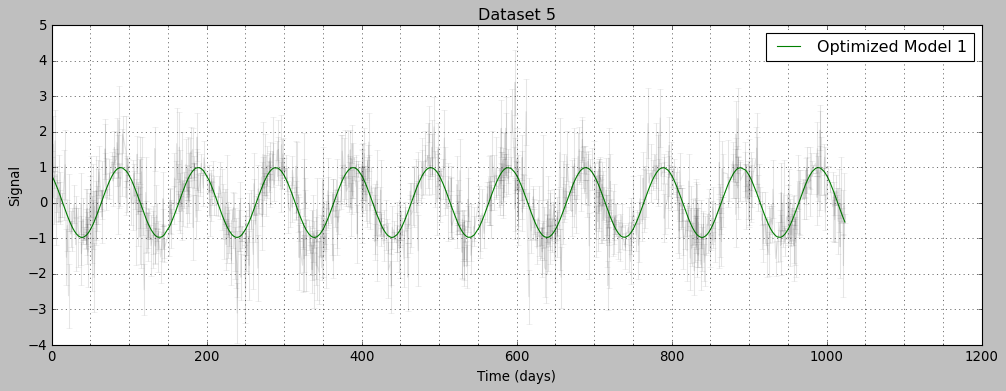

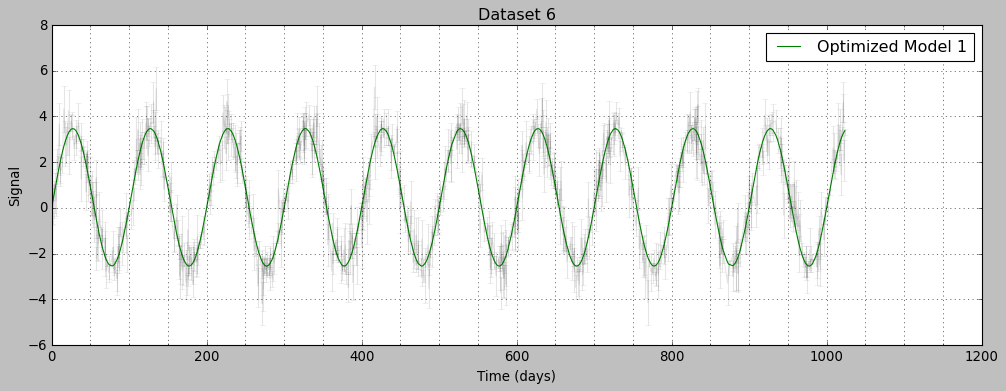

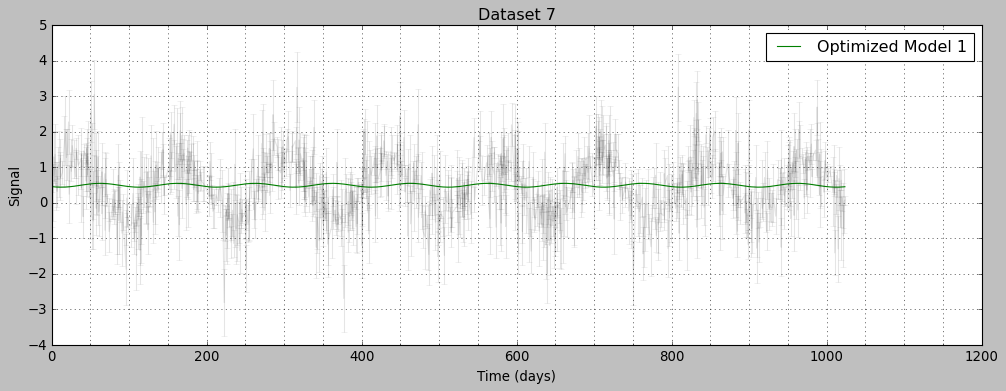

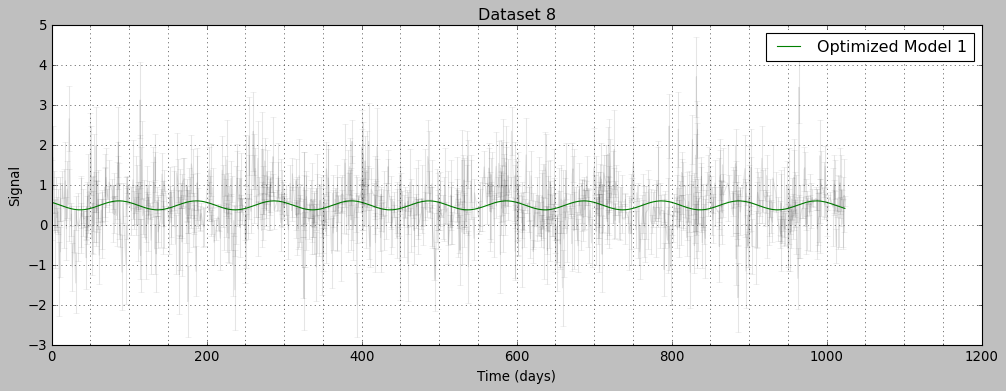

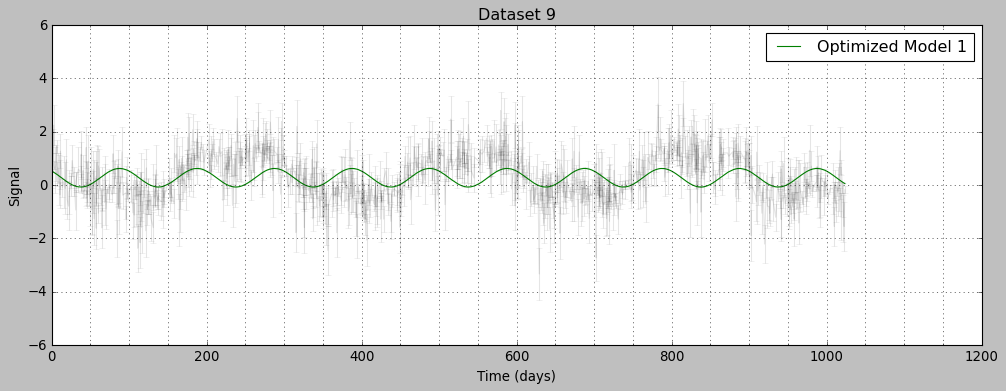

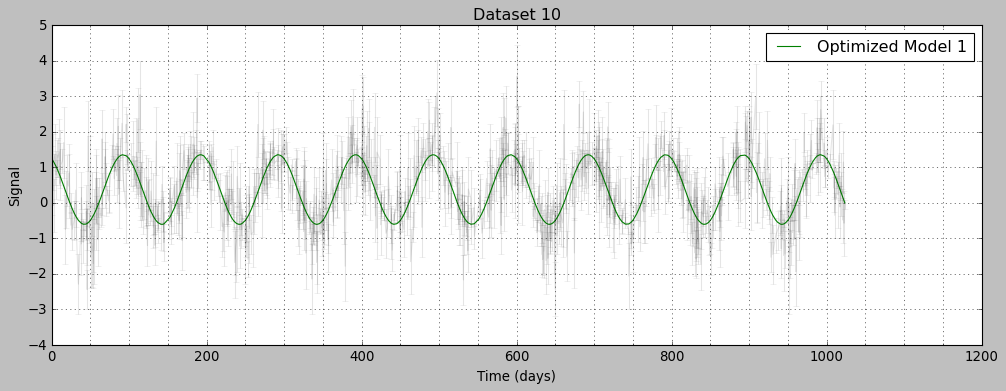

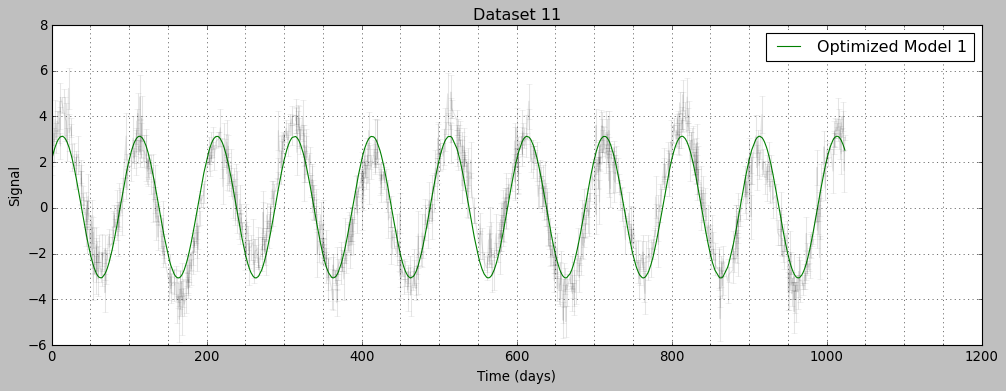

In [38]:
# Loop log-likelood function for all datapoints for each graph
Maxloglike_M1_s = pd.Series(dtype=object)
argmaxloglike_M1_s = pd.Series(dtype=object)

for i in range(2,13):
    fun = lambda x: -loglike_M1(x, (data[0],data[i]), data[1] )
    res = minimize(fun, [1,1,1])
    #print("dataset {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, res.status, -res.fun, res.x))
    # fun(x, *args) -> float
    # where x is a 1-D array with shape (n,) 
    # and args is a tuple of the fixed parameters needed to completely specify the function.
       
    Maxloglike_M1_s.at[i]= -res.fun  
    argmaxloglike_M1_s.at[i]= res.x  
    A1, A2, B = res.x                 # maximum likelihood parameters.
    A_ML_M1 = np.sqrt(A1**2 + A2**2)  # convert to original model parameters.
    #print("dataset {}, A_argmax_M1 = {} ".format(i-1, A_ML_M1))
    
    M1 = A1 * np.cos(2* np.pi/100 * data[0]) + A2 * np.sin(2* np.pi/100 * data[0]) + B
    print("Model 1 : dataset {} --> A1 = {},  A2 = {}, B = {} ".format(i-1, A1, A2, B))
    
    # Plot function for optimized parameters (A_1, A_2, B)
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", alpha=0.1)
    pyplt.plot(data[0], M1, color='green', alpha=1.0, label = 'Optimized Model 1')
    pyplt.xlabel("Time (days)")
    pyplt.ylabel("Signal")
    pyplt.title("Dataset {}".format(i-1))
    plt.legend()

## Solution - Exercise 2 
#### Task: For each dataset above, is there another sinusoidal signal with a 100day period other than one in exercise 1?

Using model $M_2$ in the likelihood function ${\mathcal {L_2}}$:
$$ {\mathcal {L_2}} = -\frac{1}{2} \sum \limits _{i} ^{N} \frac{ [y_i - \mu_i]^2}{\sigma_i^2} $$

We can use the log-likelihood function to derive the maximum likelihood estimator of the parameters $ \theta = A_1, A_2, A_3, A_4, T', B$ given the data $X$
$${\displaystyle {\hat {\theta }}=\operatorname {argmax} _{A_1, A_2, A_3, A_4, T', B \in \theta}{\mathcal {L_2}}(\theta \mid X)} $$

By utlizing the profile approach, we will choose $T'$:
$$\theta = (T', A_1,A_2,A_3,A_4,B) = ( T', \alpha(T') )$$

Therefore, at each $T'$,
$$\hat{\alpha}(T')=\operatorname {argmax} _{\alpha(T') \in \theta} \mathcal{L_2}(\alpha(T')|X) $$


We can define the log-likelihood function by,
$$ loglike(pars, data, info) = \log\left[P(data|pars)\right] = \hat{\alpha}(T') = \displaystyle {\hat \theta } $$
where,
- pars: model parameters $(A_1,A_2,A_3,A_4,B)$
- data: data points ($t_i, y_i)$, $1xN$ arrays $( [t_1, ... ,t_N],[y_1, ..., y_N] )$
- info: $y_i$ uncertainties $(\sigma_i)$, a $1xN$ array $[\sigma_1,...,\sigma_N]$

In [19]:
# Create the definition for our log-likelihood function and what it returns
def loglike_M2(pars, data, info):
    Tp,A1,A2,A3,A4,B = pars
    t, y = data
    sig = info
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t)+ A1 * np.cos(2* np.pi/100 * t) + A2 * np.sin(2* np.pi/100 * t) + B 

    return -0.5 * np.sum( ((y - mu)/sig )**2 )


## Test M2 log-likelihood function for simple case if Tp=1, A1=1, A2=1, A3=1, A4=1, B=0
theta = (1,1,1,1,1,0)
loglike_M2(theta, (data[0],data[2]), data[1])

-9265.33707108336

Model 2 : dataset 1 --> Tp_max = 358.30612244897964, A1 = 0.009822410634486146,  A2 = -0.00042315826366490797, A3 = -0.020401710549346707, A4 = 0.017258042907733896, B = 0.006113486621526976 
Model 2 : dataset 2 --> Tp_max = 120.10204081632654, A1 = 0.026009873055802185,  A2 = 0.0474043180555133, A3 = -0.019595330185532694, A4 = 0.032916688867474966, B = 0.2841996732538302 
Model 2 : dataset 3 --> Tp_max = 209.42857142857144, A1 = -0.08741606197024437,  A2 = 0.08582612641151448, A3 = 0.04085133800022409, A4 = 0.01194310034419268, B = 0.09687143086218986 
Model 2 : dataset 4 --> Tp_max = 477.40816326530614, A1 = 0.1869976906119146,  A2 = 0.24924230694510985, A3 = 0.020872332620676493, A4 = 0.03790451633755649, B = 0.5216868967877273 
Model 2 : dataset 5 --> Tp_max = 120.10204081632654, A1 = 0.7601575522826329,  A2 = -0.613632183683469, A3 = -0.02685130967189232, A4 = 0.026313052862739474, B = 0.006137642802734785 
Model 2 : dataset 6 --> Tp_max = 30.775510204081634, A1 = -0.462292490229

/var/folders/zn/wknmd3793w1b08wgws1qx64m0000gp/T/ipykernel_18272/1627643926.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pyplt.figure(figsize=(15, 5))


Model 2 : dataset 11 --> Tp_max = 268.9795918367347, A1 = 1.985770666304129,  A2 = 2.295740542380861, A3 = 0.7440795435868349, A4 = 0.18206215245715038, B = 0.10609704863840365 


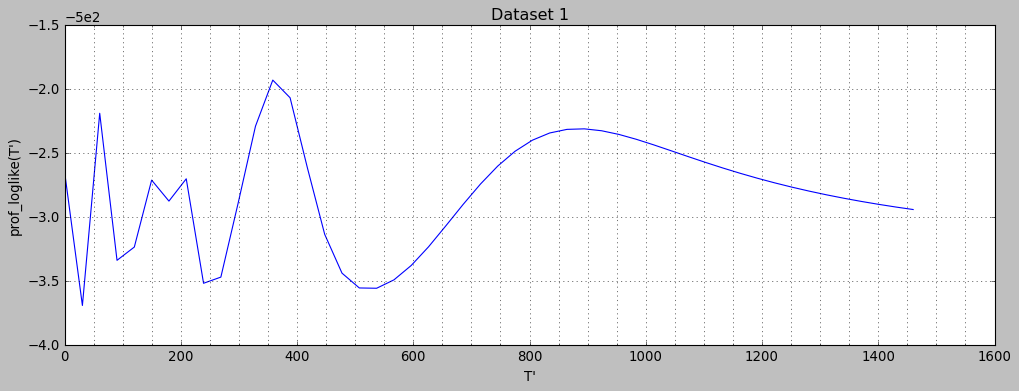

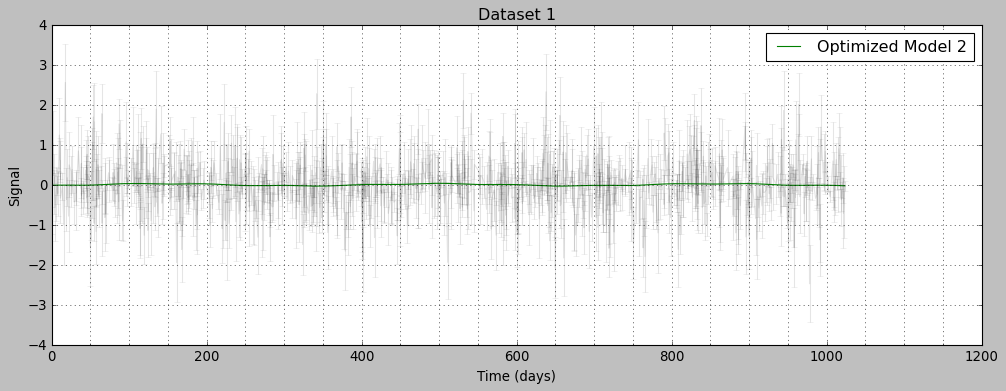

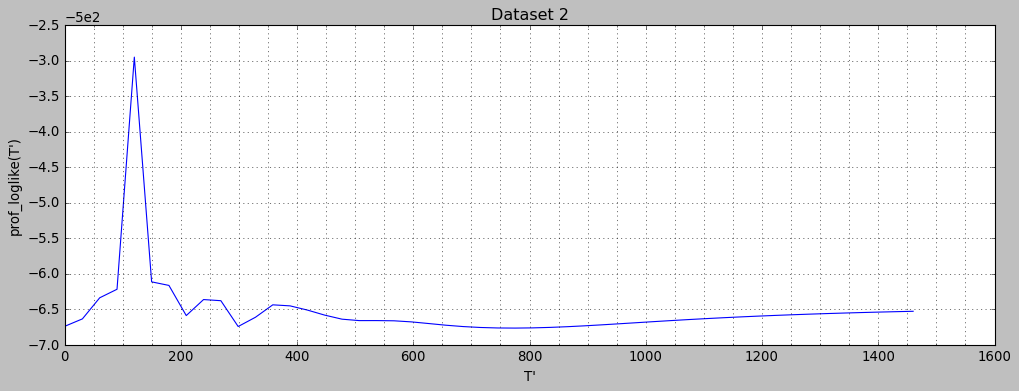

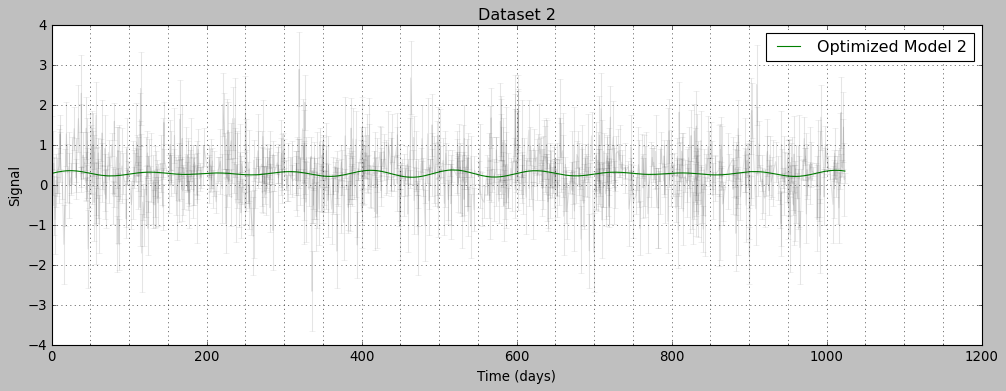

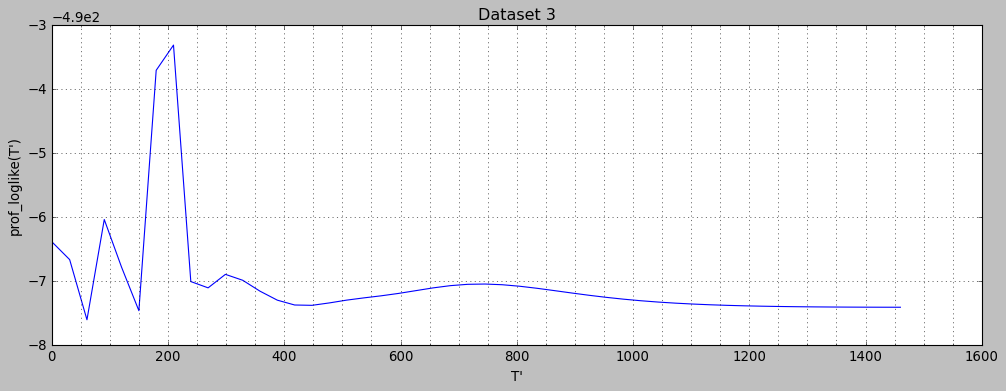

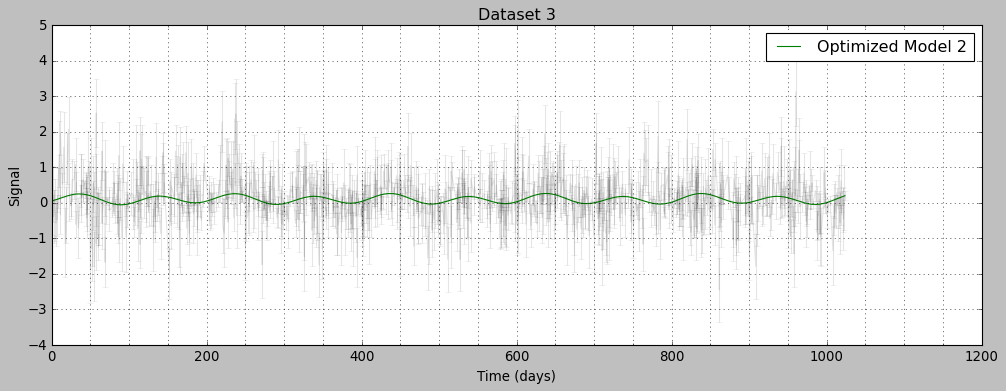

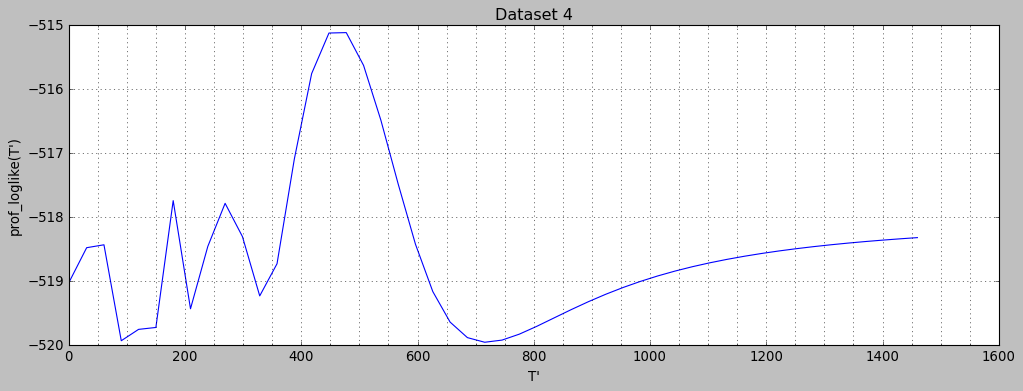

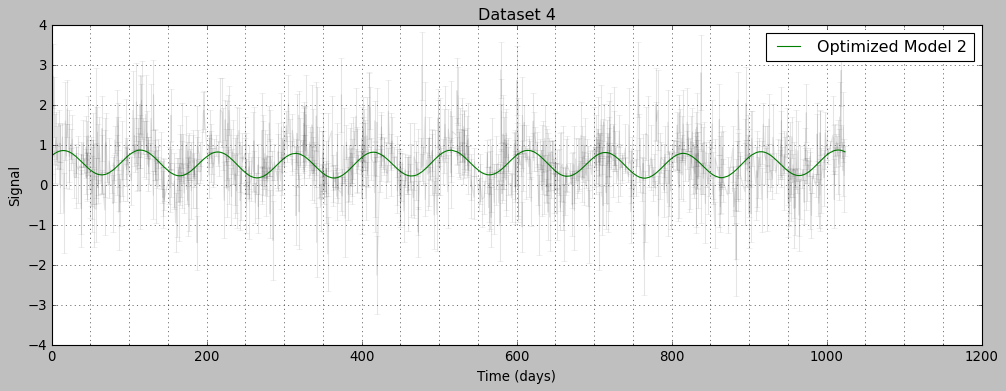

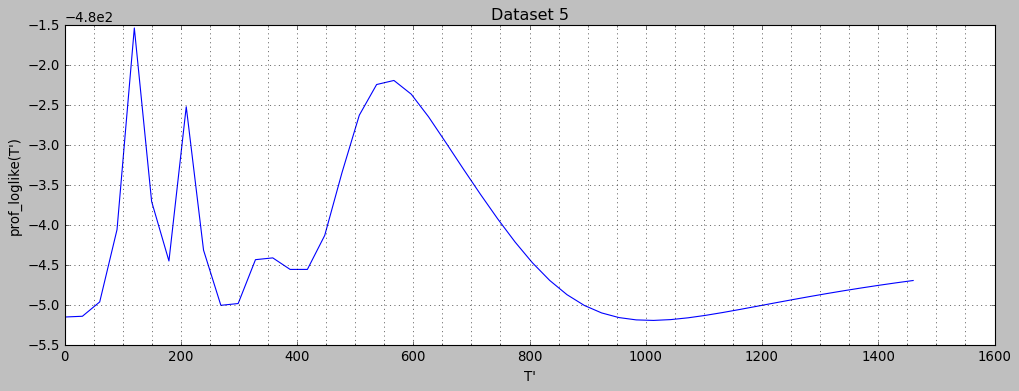

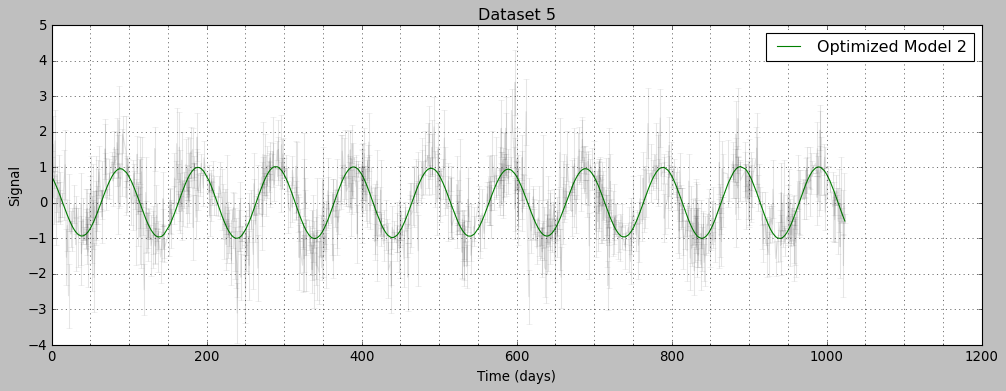

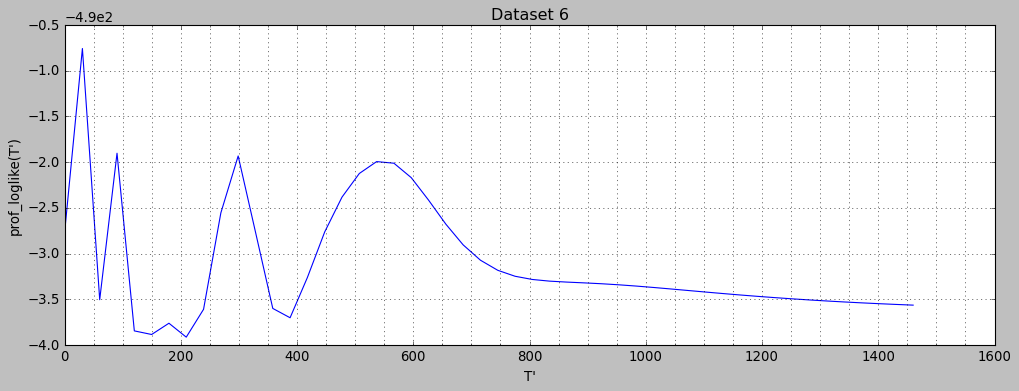

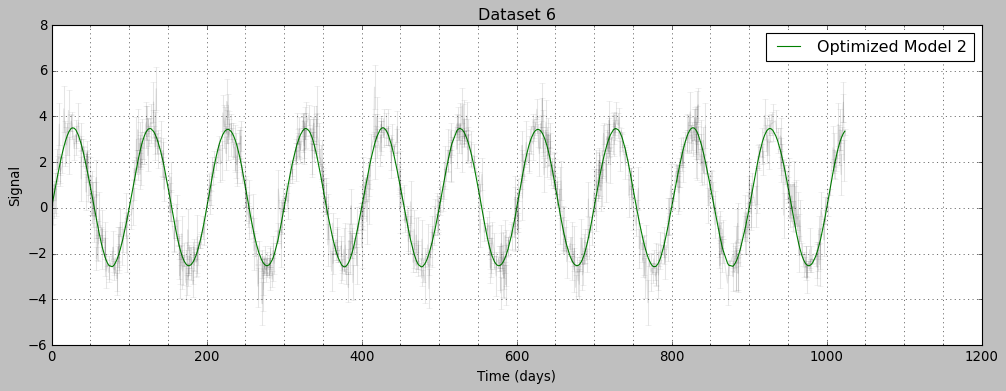

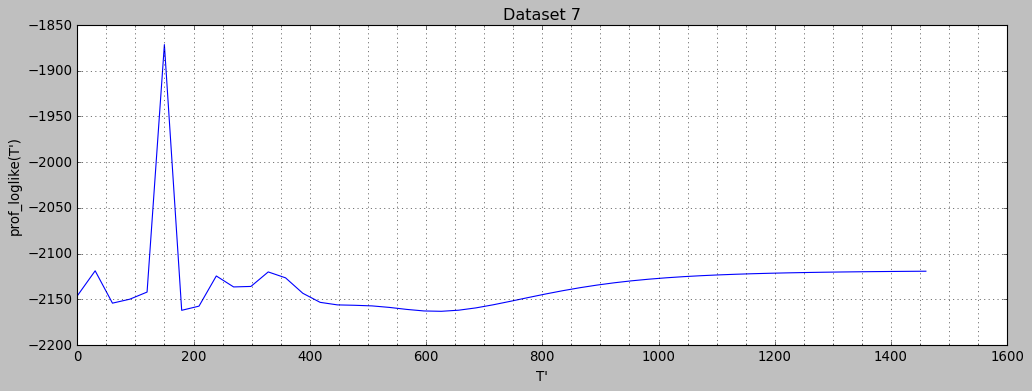

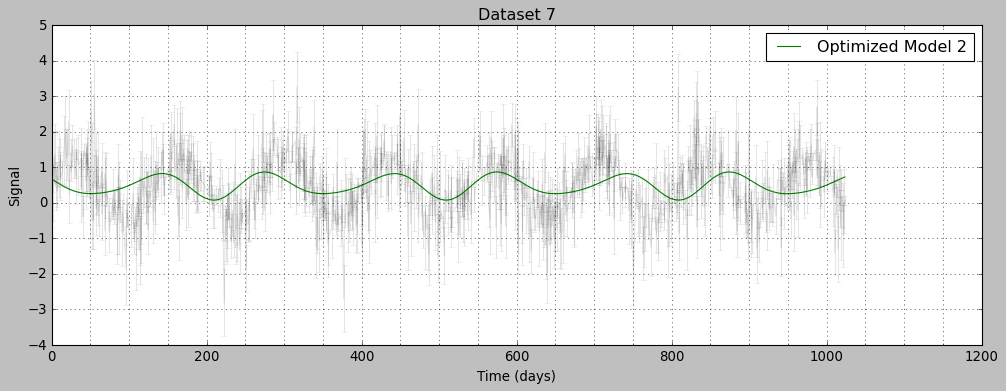

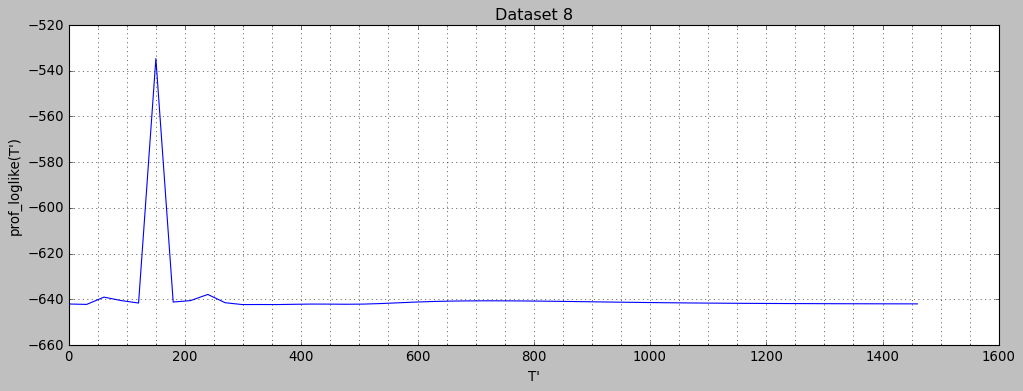

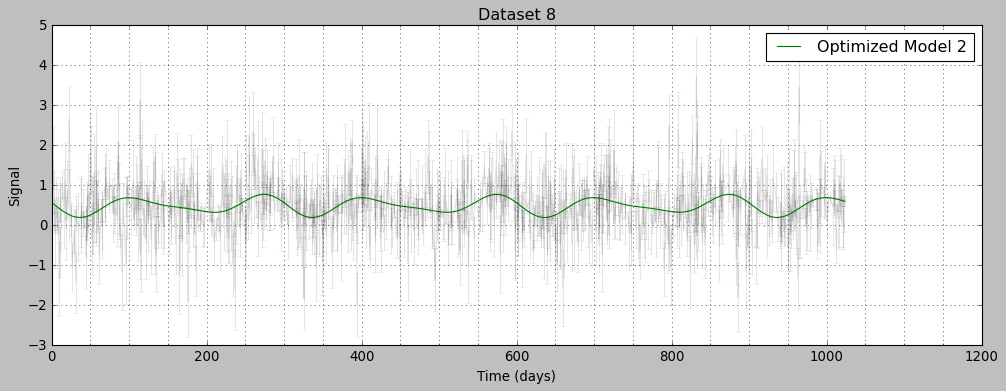

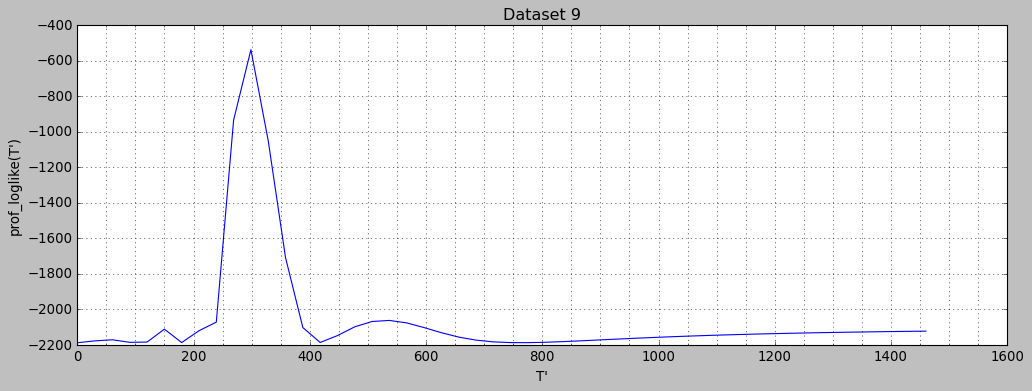

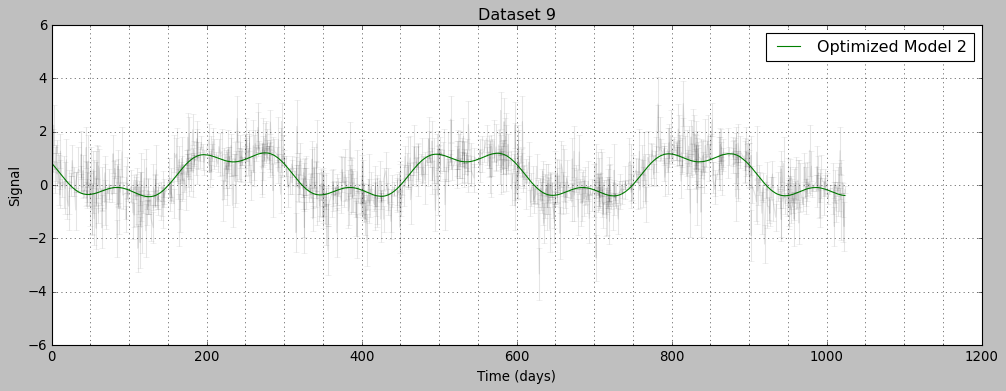

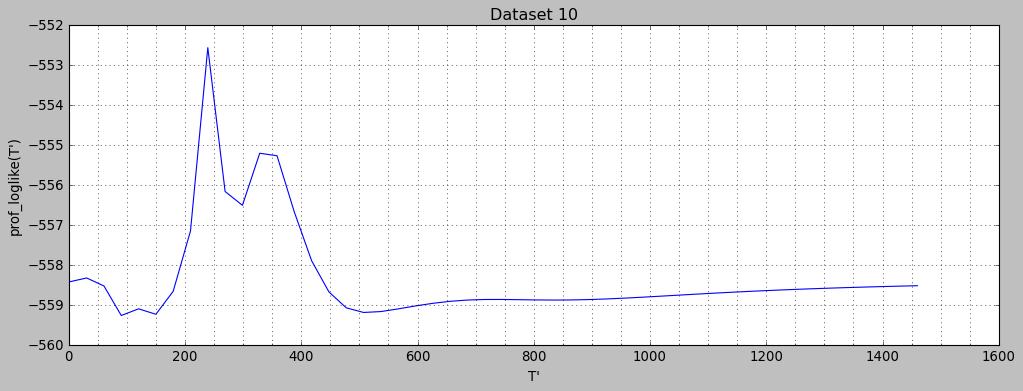

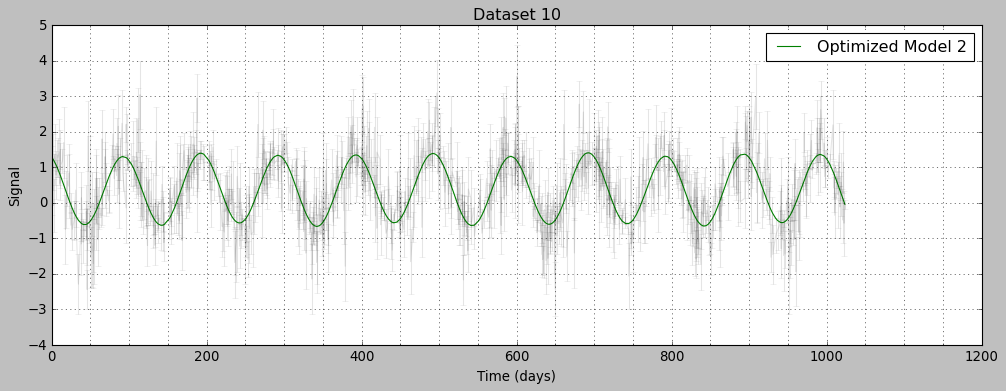

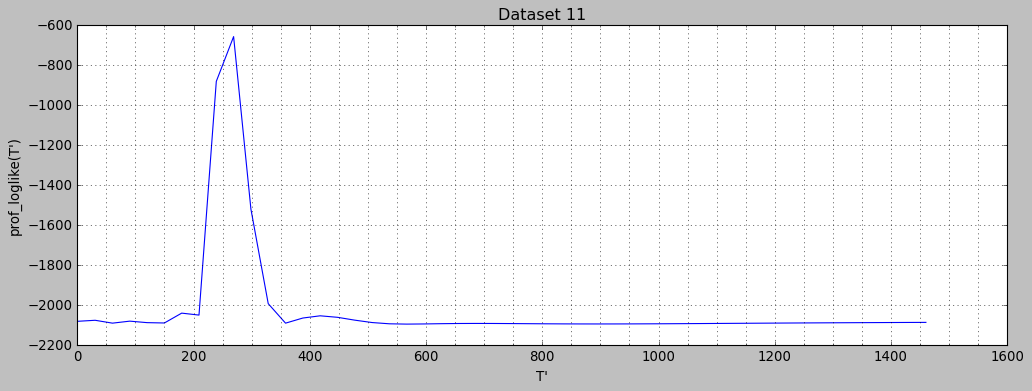

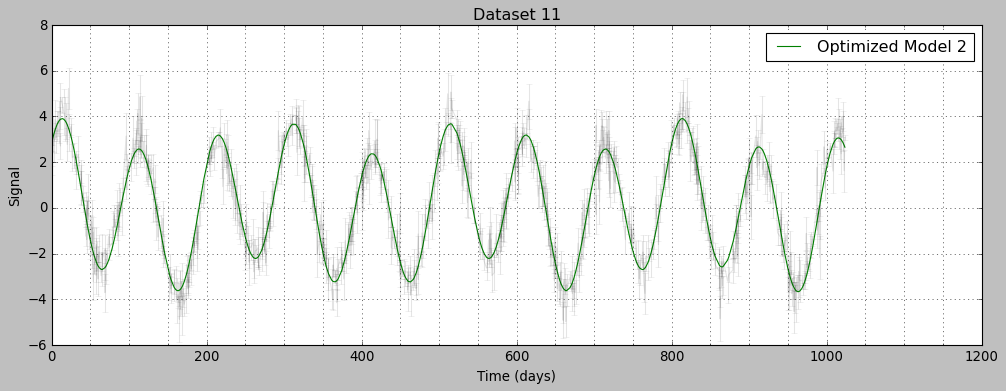

In [39]:
T = 100
profloglike_s = pd.Series(dtype=object)
Tp_max = pd.Series(dtype=object)
Maxloglike_M2_s = pd.Series(dtype=object)
argmaxloglike_M2_s = pd.Series(dtype=object)

for i in range(2,13):
    Tps = np.linspace(1,1460,50)
    profloglike_s.at[i] = []
    for Tp in Tps:
        fun = lambda a: -loglike_M2( np.concatenate(([Tp],a)), (data[0],data[i]), data[1] )  
        res_Tp = minimize( fun, [1,1,1,1,1] )
        profloglike_s.at[i].append(-res_Tp.fun)
        
    # Plot Optimized Period vs log likelihood
    Tp_max.at[i] = Tps[np.argmax(prologlike_s.at[i])]
    pyplt.figure(figsize=(15, 5))
    pyplt.plot(Tps, profloglike_s.at[i])
    pyplt.xlabel("T'")
    pyplt.ylabel("prof_loglike(T')")
    pyplt.title("Dataset {}".format(i-1))
    
    
    # Reoptimize rest of parameters (A_1, A_2, A_3, A_4, B) using respective optimized T'
    fun = lambda a: -loglike_M2( np.concatenate(([ Tp_max.at[i] ],a)), (data[0],data[i]), data[1] ) 
    res = minimize( fun, [1,1,1,1,1])
    #print("dataset {}, Tp_argmax_M2 = {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, Tp_max.at[i], res.status, -res.fun, res.x))  
    
    Maxloglike_M2_s.at[i]= -res.fun  
    argmaxloglike_M2_s.at[i]= res.x  
    A1,A2,A3,A4,B = res.x                     # maximum likelihood parameters
    A_ML_M2_signal1 = np.sqrt(A1**2 + A2**2)  # convert to original model parameters
    A_ML_M2_signal2 = np.sqrt(A3**2 + A4**2)  # convert to original model parameters
    #print("dataset {},  A_argmax_M2_signal1 = {}, A_argmax_M2_signal2 = {}  ".format(i-1, A_ML_M2_signal1, A_ML_M2_signal2 ))
    
    M2 = A3 * np.cos(2* np.pi/Tp_max.at[i] * data[0]) + A4 * np.sin(2* np.pi/Tp_max.at[i] * data[0]) + A1 * np.cos(2* np.pi/T * data[0]) + A2 * np.sin(2* np.pi/T * data[0]) + B 
    print("Model 2 : dataset {} --> Tp_max = {}, A1 = {},  A2 = {}, A3 = {}, A4 = {}, B = {} ".format(i-1, Tp_max.at[i], A1, A2, A3, A4, B))
    
    # Plot function for optimized parameters (A_1, A_2, A_3, A_4, B) for each each respective T' 
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", alpha=0.1)
    pyplt.plot(data[0], M2, color='g', alpha=1.0, label = 'Optimized Model 2')
    pyplt.xlabel("Time (days)")
    pyplt.ylabel("Signal")
    pyplt.title("Dataset {}".format(i-1))
    plt.legend()

## Solution - Exercise 3 
#### Task: For each dataset above, treat the signal found in excercise 2 as nuisance parameters and repeat exercise 1. Are there any changes?

Using model $M_2$ in the likelihood function ${\mathcal {L_2}}$:
$$ {\mathcal {L_2}} = -\frac{1}{2} \sum \limits _{i} ^{N} \frac{ [y_i - \mu_i]^2}{\sigma_i^2} $$

In excercise 2 we found the maximum likelihood for our parameters $\theta = (T', A_1,A_2,A_3,A_4,B) = ( T', \alpha(T') )$. 
- First we optimized $T'$ and then reoptimized given that $T'$  to find $ \alpha(T') = (A_1,A_2,A_3,A_4,B) $


Since given $T'$ the maximum likelihood for parameters of the second signal ($A_3,A_4$) were found while finding parameters for the first signal ($A_1, A_2$); by treating ($A_3,A_4$) as nuisance parameters, reooptimizing to find ($A_1, A_2$) will yeild the same values for ($A_3,A_4$)!

Therefore, we can just optimize for $\alpha(T') = A_1, A_2, A_3, A_4, B$ given a respective $T'$.
There are no changes in excercise 2 to excercise 3.

Model 2 : dataset 1 --> Tp_max = 358.30612244897964, A1 = 0.00982240874630464,  A2 = -0.00042315794776305864, A3 = -0.02040171114583435, A4 = 0.017258042178168228, B = 0.006113486225825256 
Model 2 : dataset 2 --> Tp_max = 120.10204081632654, A1 = 0.026009872716874893,  A2 = 0.047404316719442265, A3 = -0.019595330546611264, A4 = 0.03291668848482137, B = 0.28419967281271485 
Model 2 : dataset 3 --> Tp_max = 209.42857142857144, A1 = -0.0874160618565928,  A2 = 0.0858261271878895, A3 = 0.04085133933924833, A4 = 0.011943099944920002, B = 0.09687143115074914 
Model 2 : dataset 4 --> Tp_max = 477.40816326530614, A1 = 0.18699768859029123,  A2 = 0.24924230497729302, A3 = 0.020872330839410043, A4 = 0.03790451563879904, B = 0.5216868964124179 
Model 2 : dataset 5 --> Tp_max = 120.10204081632654, A1 = 0.7601575502704413,  A2 = -0.6136321869111523, A3 = -0.026851315044563354, A4 = 0.026313049626956814, B = 0.006137644136647618 
Model 2 : dataset 6 --> Tp_max = 30.775510204081634, A1 = -0.4622924909

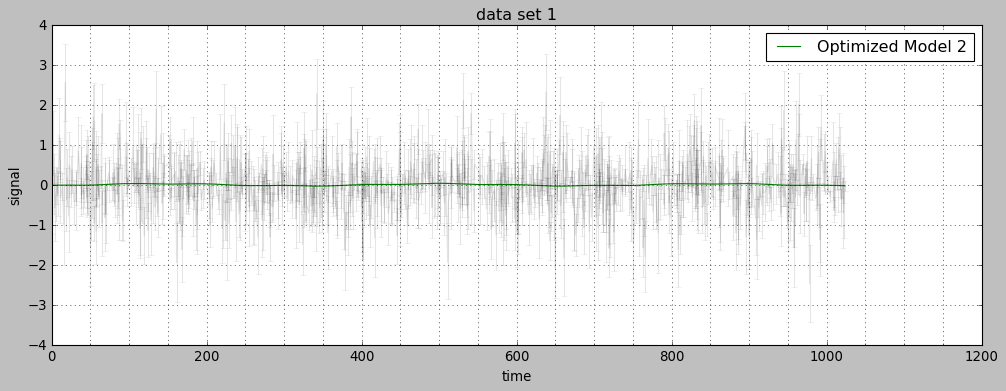

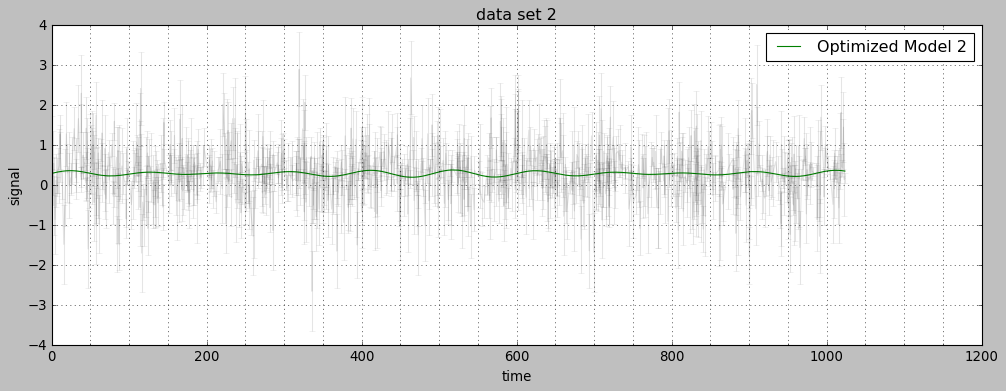

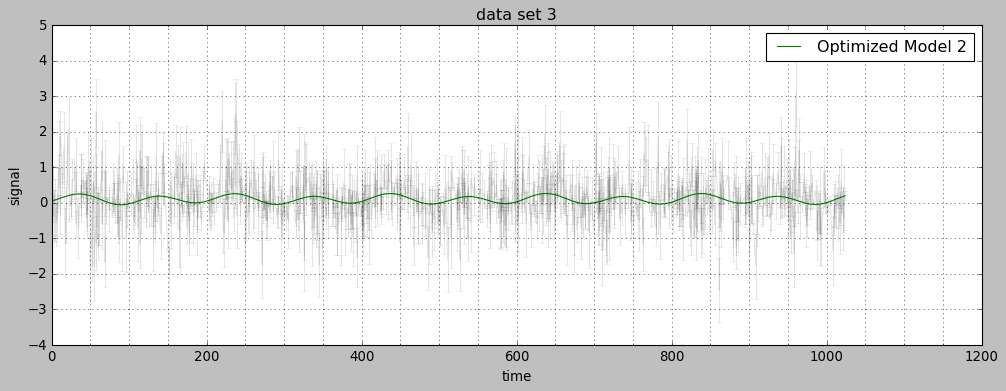

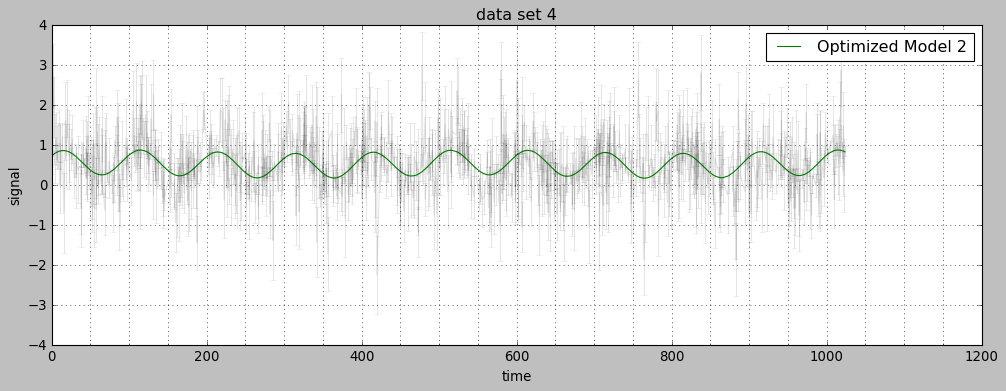

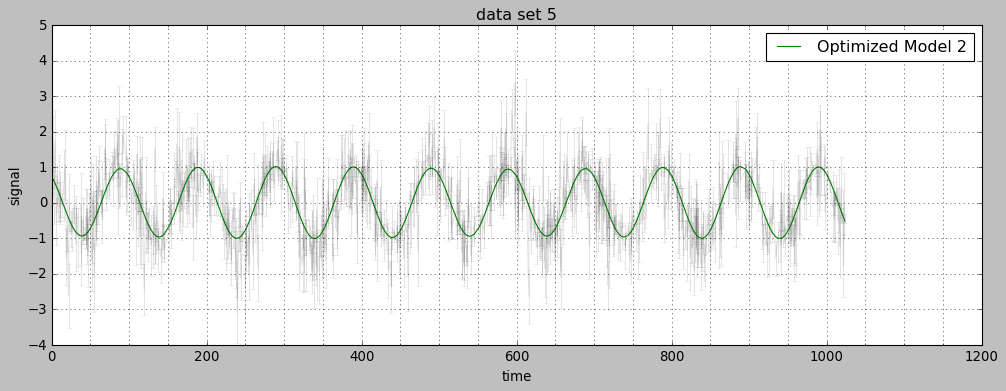

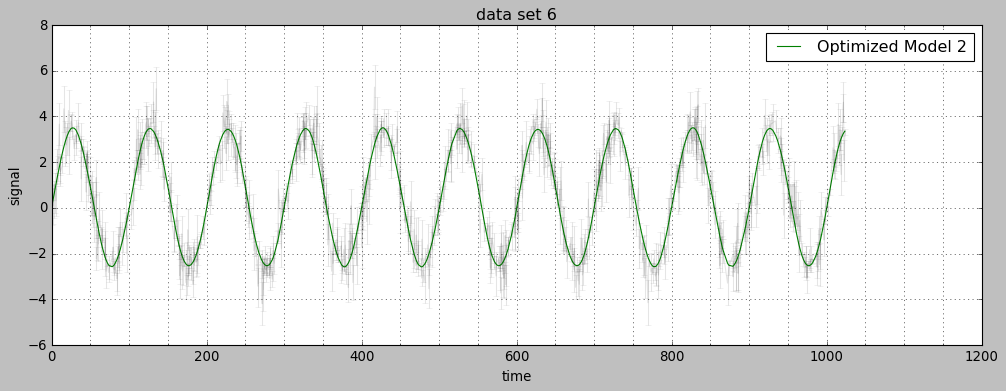

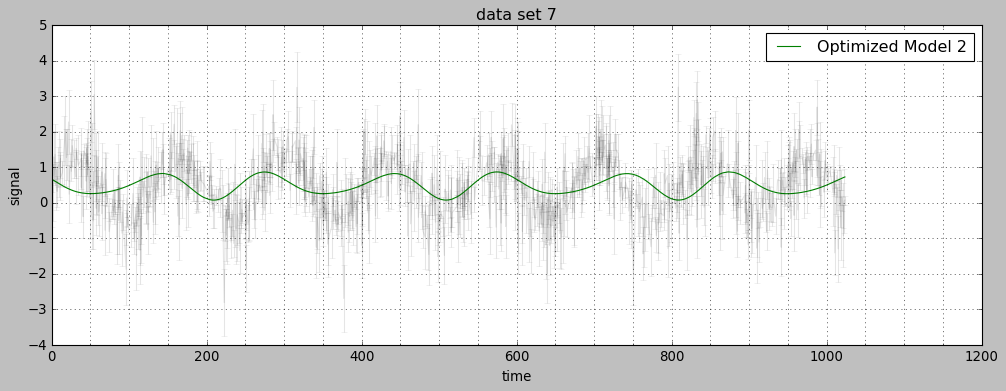

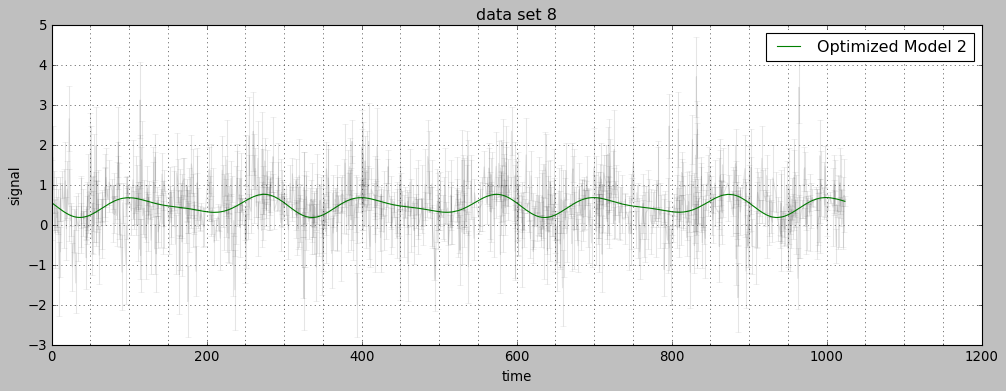

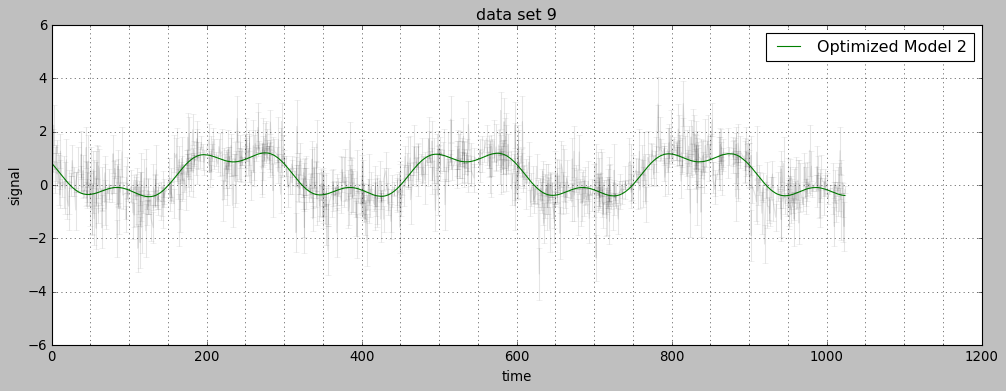

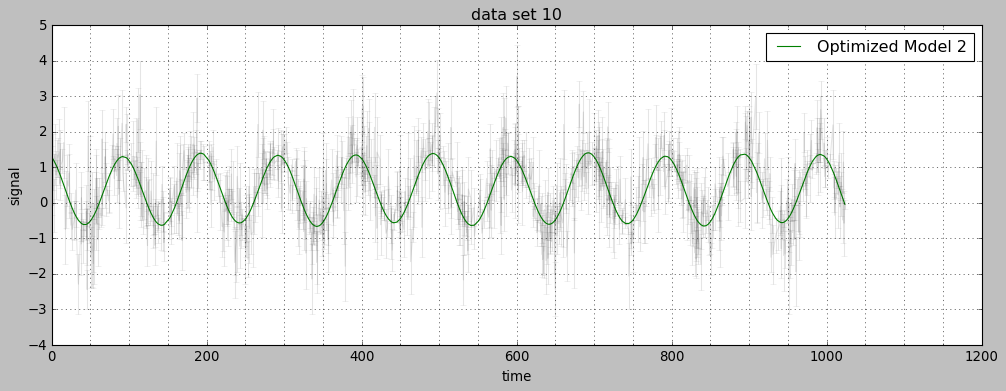

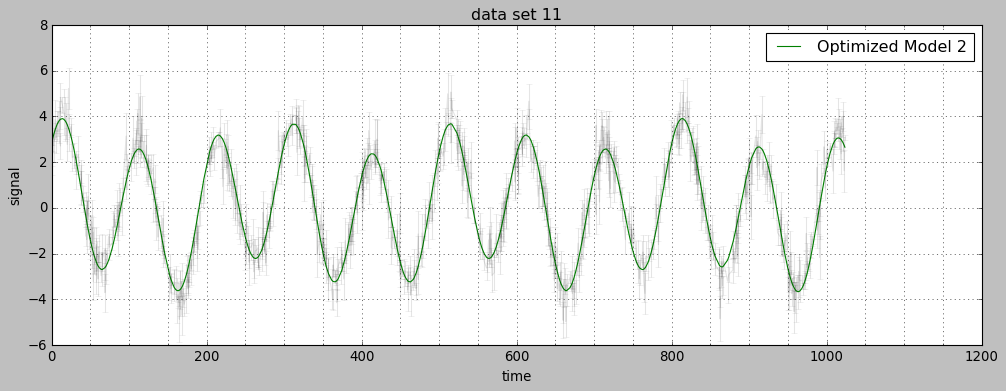

In [41]:
T = 100
Maxloglike_M2_s = pd.Series(dtype=object)
argmaxloglike_M2_s = pd.Series(dtype=object)

for i in range(2,13):
    # Reoptimize rest of parameters (A_1, A_2, A_3, A_4, B) using respective optimized T'
    fun = lambda a: -loglike_M2( np.concatenate(([ Tp_max.at[i] ],a)), (data[0],data[i]), data[1] )
    res = sci.optimize.minimize( fun, [1,1,1,1,0])
    #print("dataset {}, Tp_argmax_M2 = {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, Tp_max.at[i], res.status, -res.fun, res.x))  
    
    Maxloglike_M2_s.at[i]= -res.fun  
    argmaxloglike_M2_s.at[i]= res.x  
    A1, A2, A3, A4, B = res.x                 # maximum likelihood parameters.
    A_ML_M2_signal1 = np.sqrt(A1**2 + A2**2)  # convert to original model parameters
    A_ML_M2_signal2 = np.sqrt(A3**2 + A4**2)  # convert to original model parameters
    #print("dataset {},  A_argmax_M2_signal1 = {}, A_argmax_M2_signal2 = {}  ".format(i-1, A_ML_M2_signal1, A_ML_M2_signal2 ))
    
    M2 = A3 * np.cos(2* np.pi/Tp_max.at[i] * data[0]) + A4 * np.sin(2* np.pi/Tp_max.at[i] * data[0]) + A1 * np.cos(2* np.pi/T * data[0]) + A2 * np.sin(2* np.pi/T * data[0]) + B
    print("Model 2 : dataset {} --> Tp_max = {}, A1 = {},  A2 = {}, A3 = {}, A4 = {}, B = {} ".format(i-1, Tp_max.at[i], A1, A2, A3, A4, B))
    
    # Plot function for optimized parameters (A_1, A_2, A_3, A_4, B) for each each respective T'
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", alpha=0.1)
    pyplt.plot(data[0], M2, color='g', alpha=1.0, label = 'Optimized Model 2')
    pyplt.xlabel("time")
    pyplt.ylabel("signal")
    pyplt.title("data set {}".format(i-1))
    plt.legend()

Here I plugged in ($T',A_3,A_4$) and reooptimized to find ($A_1, A_2, B$). The answers are the same as before.

Model 1 : dataset 1 --> Tp_max = 358.30612244897964, A1 = 0.009822410309239929,  A2 = -0.00042315546432592735, A3 = -0.02040171114583435, A4 = 0.017258042178168228, B = 0.006113486468018991 
Model 1 : dataset 2 --> Tp_max = 120.10204081632654, A1 = 0.02600987231951995,  A2 = 0.04740431772895461, A3 = -0.019595330546611264, A4 = 0.03291668848482137, B = 0.28419967312924155 
Model 1 : dataset 3 --> Tp_max = 209.42857142857144, A1 = -0.08741606264376568,  A2 = 0.0858261267762897, A3 = 0.04085133933924833, A4 = 0.011943099944920002, B = 0.09687143066067049 
Model 1 : dataset 4 --> Tp_max = 477.40816326530614, A1 = 0.18699768839097297,  A2 = 0.249242304863041, A3 = 0.020872330839410043, A4 = 0.03790451563879904, B = 0.5216868953605328 
Model 1 : dataset 5 --> Tp_max = 120.10204081632654, A1 = 0.7601575503264708,  A2 = -0.6136321890552102, A3 = -0.026851315044563354, A4 = 0.026313049626956814, B = 0.006137645644995768 
Model 1 : dataset 6 --> Tp_max = 30.775510204081634, A1 = -0.462292491042

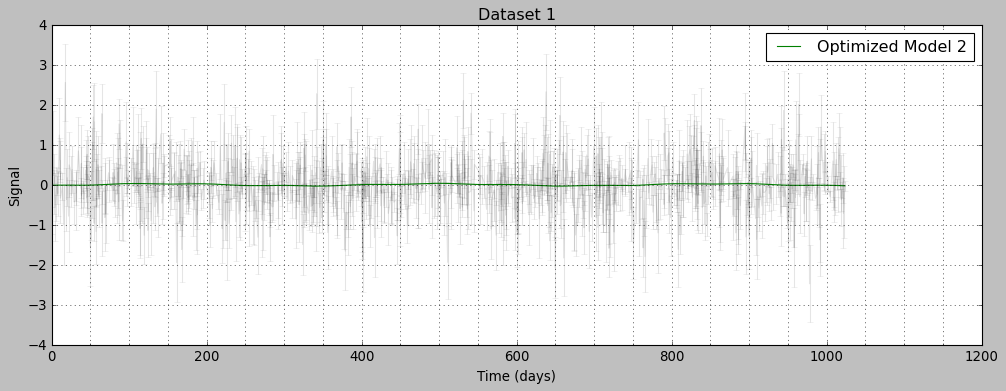

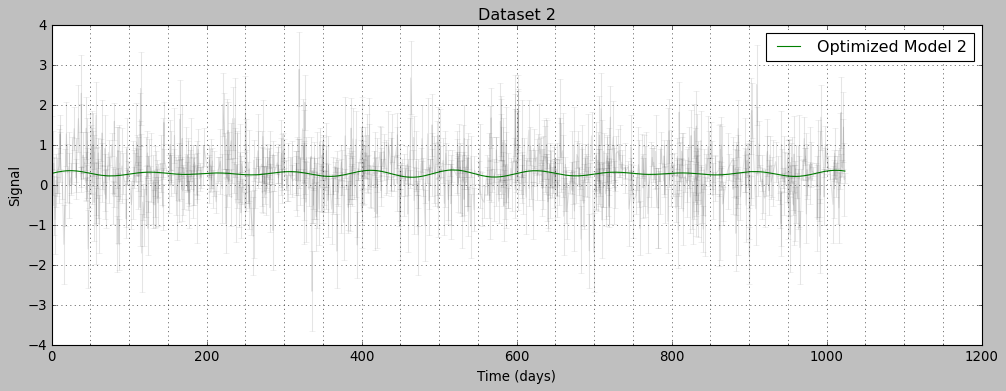

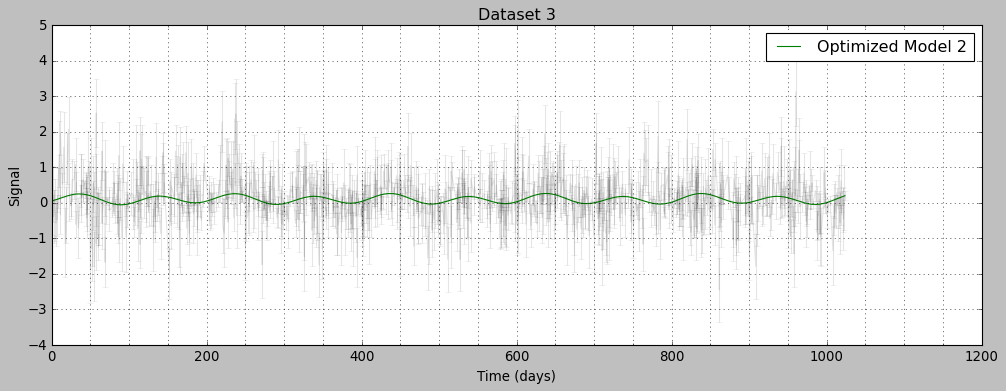

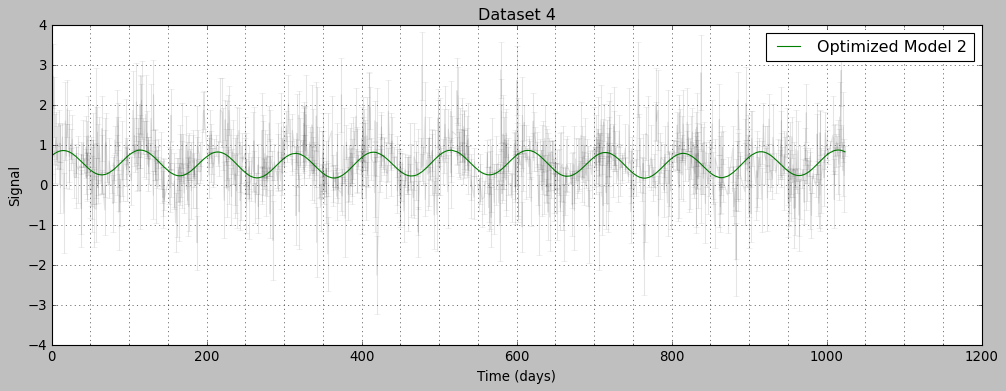

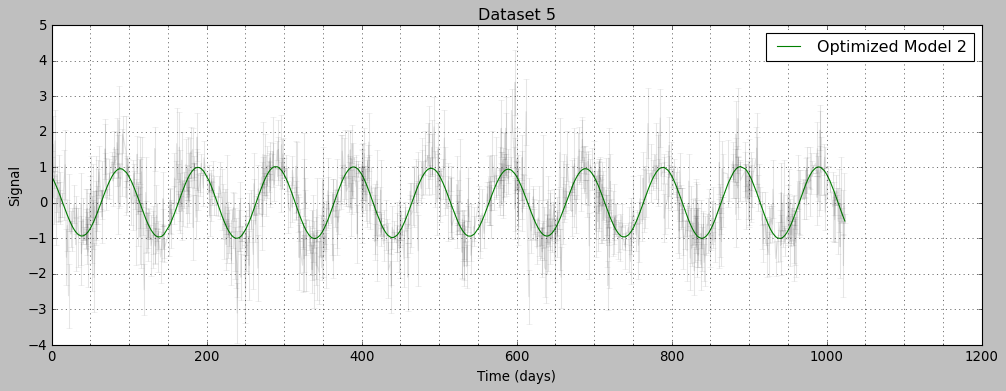

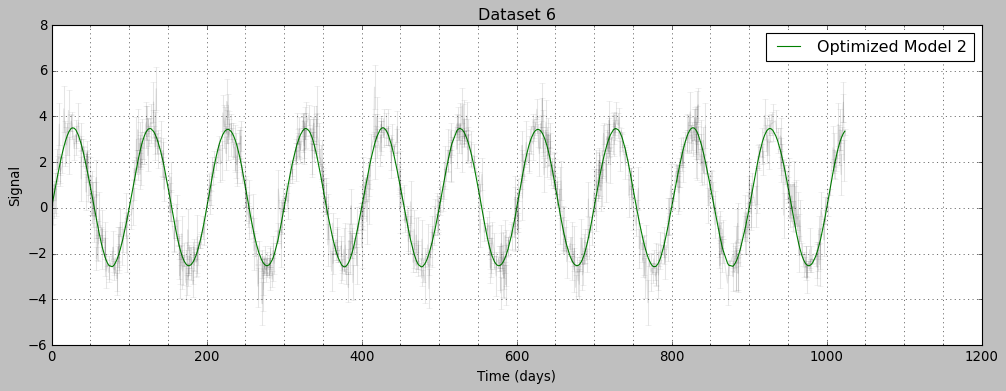

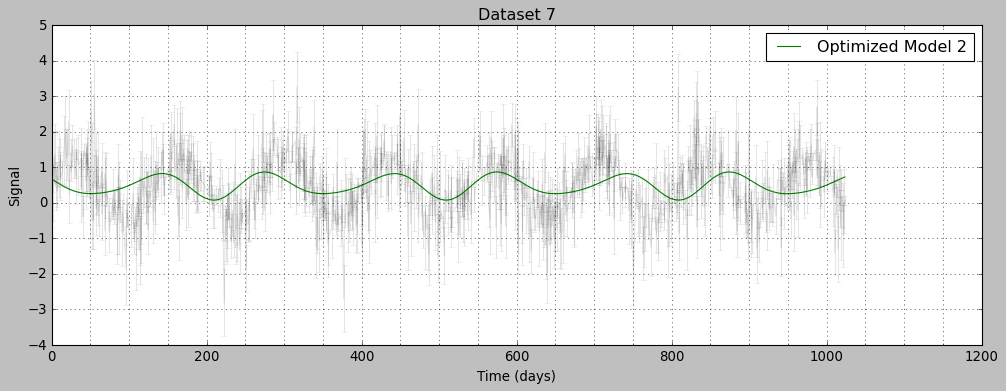

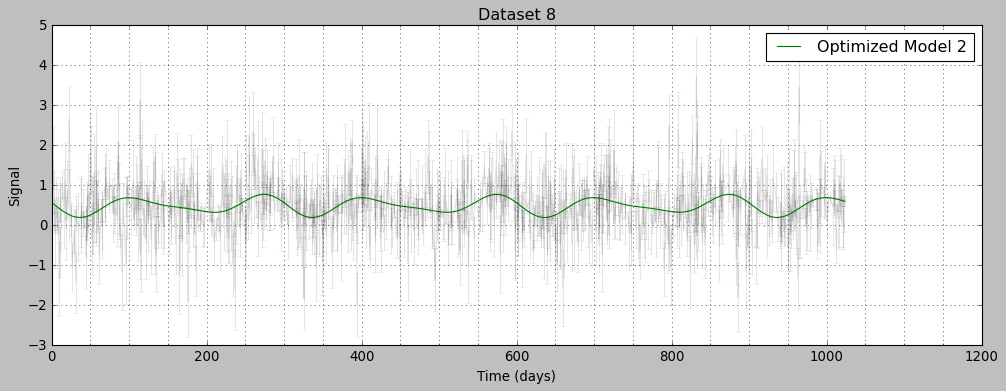

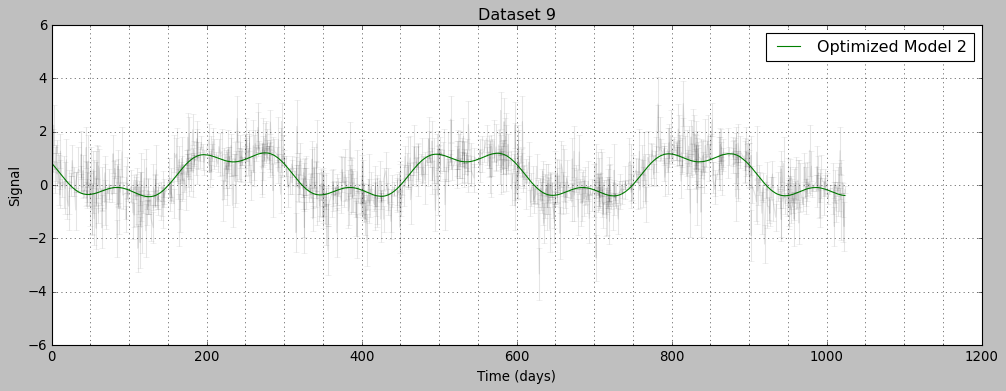

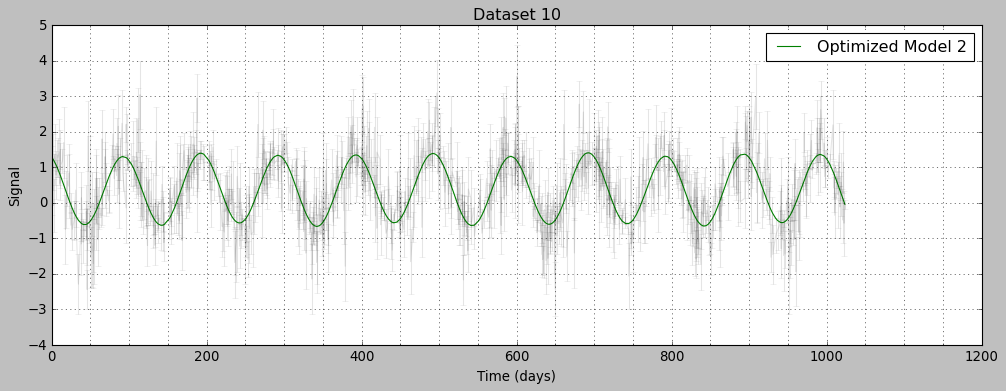

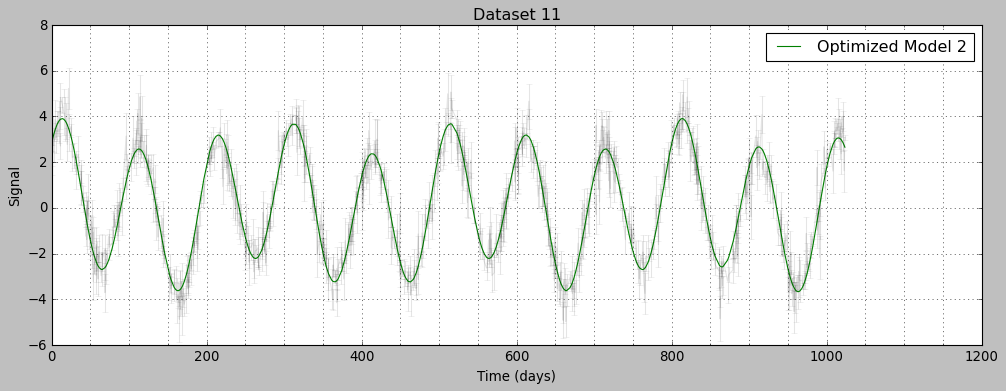

In [42]:
def loglike_M2p(pars, data, info):
    Tp,A3,A4,A1,A2,B = pars
    t, y = data
    sig = info
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t)+ A1 * np.cos(2* np.pi/100 * t) + A2 * np.sin(2* np.pi/100 * t) + B 

    return -0.5 * np.sum( ((y - mu)/sig )**2 )

nusi_max_A3 = pd.Series(dtype=object)
nusi_max_A4 = pd.Series(dtype=object)
Maxloglike_M2p_s = pd.Series(dtype=object)
argmaxloglike_M2p_s = pd.Series(dtype=object)

for i in range(2,13):
    # Reoptimize rest of parameters (A_1, A_2, B) using respective optimized A_3, A_4, T'
    nusi_max_A3.at[i] = argmaxloglike_M2_s.at[i][2] # Use optimized A3 for given T', nuisance parameter
    nusi_max_A4.at[i] = argmaxloglike_M2_s.at[i][3] # Use optimized A4 for given T', nuisance parameter
    #print("dataset {}, nusmax_A3 = {}, nusimax_A4 = {} ".format(i-1, nusi_max_A3.at[i], nusi_max_A4.at[i])) 
    
    fun = lambda a: -loglike_M2p( np.concatenate(([ Tp_max.at[i], nusi_max_A3.at[i], nusi_max_A4.at[i] ], a)), (data[0],data[i]), data[1] )
    res = sci.optimize.minimize( fun, [1,1,0])
    #print("dataset {}, Tp_argmax_M2 = {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, Tp_max.at[i], res.status, -res.fun, res.x))  
    Maxloglike_M2p_s.at[i]= -res.fun  
    argmaxloglike_M2p_s.at[i]= res.x  

    A1, A2, B = res.x                         # maximum likelihood parameters.
    A_ML_M2_signal1 = np.sqrt(A1**2 + A2**2)                              # convert to original model parameters
    A_ML_M2_signal2 = np.sqrt(nusi_max_A3.at[i]**2 + nusi_max_A4.at[i]**2)  # convert to original model parameters
    #print("dataset {},  A_argmax_M2_signal1 = {}, A_argmax_M2_signal2 = {}  ".format(i-1, A_ML_M2_signal1, A_ML_M2_signal2 ))
    
    M2 = nusi_max_A3.at[i] * np.cos(2* np.pi/Tp_max.at[i] * data[0]) + nusi_max_A4.at[i] * np.sin(2* np.pi/Tp_max.at[i] * data[0]) + A1 * np.cos(2* np.pi/T * data[0]) + A2 * np.sin(2* np.pi/T * data[0]) + B
    print("Model 1 : dataset {} --> Tp_max = {}, A1 = {},  A2 = {}, A3 = {}, A4 = {}, B = {} ".format(i-1, Tp_max.at[i], A1, A2, nusi_max_A3.at[i], nusi_max_A4.at[i], B))
    
    # Plot function for optimized parameters (A_1, A_2, B) for each each respective T', A_3, A_4,
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", alpha=0.1)
    pyplt.plot(data[0], M2, color='g', alpha=1.0, label = 'Optimized Model 2')
    pyplt.xlabel("Time (days)")
    pyplt.ylabel("Signal")
    pyplt.title("Dataset {}".format(i-1))
    plt.legend()